In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the cases
df = pd.read_json('public_cases.json')
df.head()

,input,expected_output
0,"{'trip_duration_days': 3, 'miles_traveled': 93...",364.51
1,"{'trip_duration_days': 1, 'miles_traveled': 55...",126.06
2,"{'trip_duration_days': 1, 'miles_traveled': 47...",128.91
3,"{'trip_duration_days': 2, 'miles_traveled': 13...",203.52
4,"{'trip_duration_days': 3, 'miles_traveled': 88...",380.37


Original columns: ['input', 'expected_output']
Sample input dict: {'trip_duration_days': 3, 'miles_traveled': 93, 'total_receipts_amount': 1.42}
Type of input: <class 'dict'>
Expanded columns: ['trip_duration_days', 'miles_traveled', 'total_receipts_amount', 'expected_output']
   trip_duration_days  miles_traveled  total_receipts_amount  expected_output
0                 3.0            93.0                   1.42           364.51
1                 1.0            55.0                   3.60           126.06
2                 1.0            47.0                  17.97           128.91
3                 2.0            13.0                   4.67           203.52
4                 3.0            88.0                   5.78           380.37
   trip_duration_days  miles_traveled  total_receipts_amount  expected_output  \
0                 3.0            93.0                   1.42           364.51   
1                 1.0            55.0                   3.60           126.06   
2          

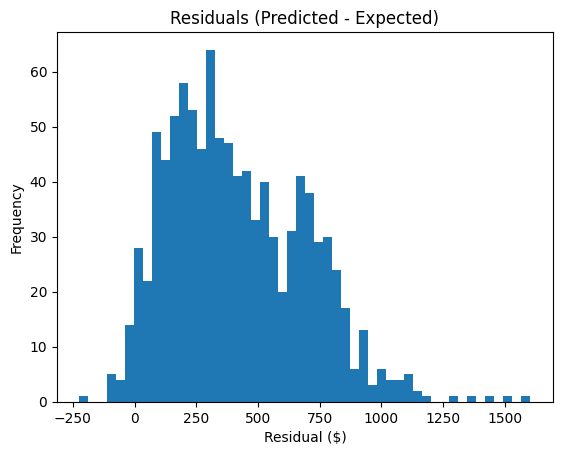

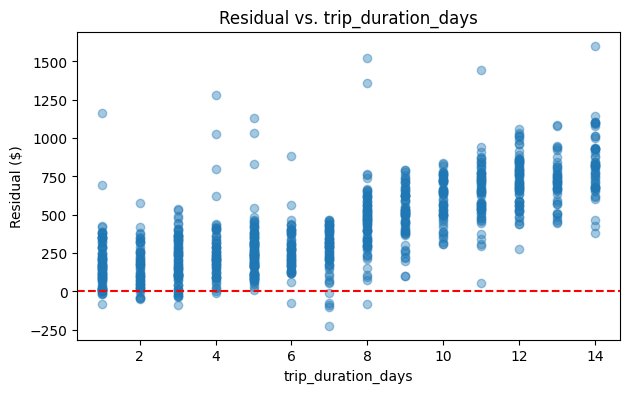

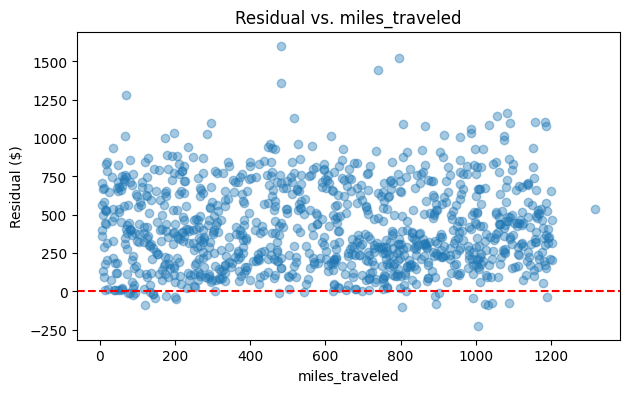

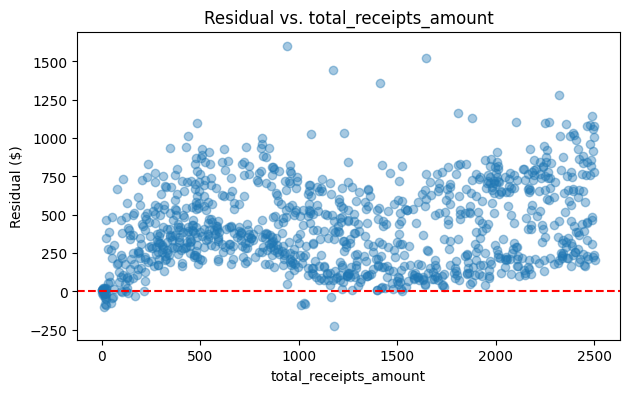


Top 10 outliers:
     trip_duration_days  miles_traveled  total_receipts_amount  \
519                14.0           481.0                 939.99   
683                 8.0           795.0                1645.99   
366                11.0           740.0                1171.99   
547                 8.0           482.0                1411.49   
151                 4.0            69.0                2321.49   
995                 1.0          1082.0                1809.49   
241                14.0          1056.0                2489.69   
710                 5.0           516.0                1878.49   
970                14.0          1158.0                2104.61   
303                14.0          1184.0                2269.89   

     expected_output  predicted  residual  
519           877.17    2480.40   1603.23  
683           644.69    2165.20   1520.51  
366           902.09    2348.40   1446.31  
547           631.81    1993.10   1361.29  
151           322.00    1604.32   1

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Load data
df = pd.read_json('public_cases.json')
print("Original columns:", df.columns.tolist())

# 2. Debug: show first 'input' row
print("Sample input dict:", df['input'].iloc[0])
print("Type of input:", type(df['input'].iloc[0]))

# 3. Expand the input dict to columns
input_df = df['input'].apply(pd.Series)
df = pd.concat([input_df, df['expected_output']], axis=1)
print("Expanded columns:", df.columns.tolist())
print(df.head())

# 4. Define the naive reimbursement formula
def naive_reimbursement(days, miles, receipts):
    per_diem = 100 * days
    mileage = 0.58 * min(miles, 100) + 0.40 * max(0, miles - 100)
    # Receipts: sweet spot logic
    if receipts < 50:
        receipts_adj = receipts * 0.5  # Penalty for low receipts
    elif receipts <= 800:
        receipts_adj = receipts
    elif receipts <= 1000:
        receipts_adj = 800 + 0.5 * (receipts - 800)
    else:
        receipts_adj = 900 + 0.2 * (receipts - 1000)
    return round(per_diem + mileage + receipts_adj, 2)

# 5. Calculate predictions
df['predicted'] = df.apply(lambda row: naive_reimbursement(
    row['trip_duration_days'],
    row['miles_traveled'],
    row['total_receipts_amount']
), axis=1)

# 6. Compute residuals
df['residual'] = df['predicted'] - df['expected_output']

# 7. Quick check
print(df[['trip_duration_days', 'miles_traveled', 'total_receipts_amount', 'expected_output', 'predicted', 'residual']].head())

# 8. Error summary
print("\nResidual stats:")
print(df['residual'].describe())

plt.hist(df['residual'], bins=50)
plt.title('Residuals (Predicted - Expected)')
plt.xlabel('Residual ($)')
plt.ylabel('Frequency')
plt.show()

# 9. Residuals vs key features
for var in ['trip_duration_days', 'miles_traveled', 'total_receipts_amount']:
    plt.figure(figsize=(7, 4))
    plt.scatter(df[var], df['residual'], alpha=0.4)
    plt.title(f'Residual vs. {var}')
    plt.xlabel(var)
    plt.ylabel('Residual ($)')
    plt.axhline(0, color='red', linestyle='--')
    plt.show()

# 10. View top outliers
df['abs_residual'] = df['residual'].abs()
worst = df.sort_values('abs_residual', ascending=False)
print("\nTop 10 outliers:")
print(worst[['trip_duration_days','miles_traveled','total_receipts_amount','expected_output','predicted','residual']].head(10))

# 11. Save for review (optional)
df.to_csv('phase2_predictions_with_residuals.csv', index=False)

### Greedy Rule Insertion

In [3]:
df['phase2_predicted'] = df['predicted']
df['phase2_residual'] = df['residual']

In [4]:
def greedy_reimbursement_final(days, miles, receipts):
    # --- Per diem logic ---
    if days >= 8:
        per_diem = 70 * days  # Long trip penalty
    elif days == 5:
        per_diem = 100 * days + 100  # 5-day bonus
    else:
        per_diem = 100 * days

    # --- Mileage logic (tiered) ---
    mileage = 0.58 * min(miles, 100) + 0.40 * max(0, miles - 100)

    # --- Receipts logic (piecewise, capped, with magic numbers) ---
    if receipts < 50:
        receipts_adj = receipts * 0.5
    elif receipts <= 800:
        receipts_adj = receipts
    elif receipts <= 1000:
        receipts_adj = 800 + 0.5 * (receipts - 800)
    else:
        receipts_adj = 900 + 0.1 * (receipts - 1000)  # Aggressive diminishing

    # --- Magic number bonus ---
    if abs(receipts - 847) < 1:
        receipts_adj += 50  # Magic number bump

    # --- Vacation penalty for long trips with high spend ---
    base = per_diem + mileage + receipts_adj
    if days >= 8 and receipts > 1000:
        base = min(base, 1000)  # Hard cap for "vacation" pattern

    # --- Hard system-wide absolute cap ---
    base = min(base, 1100)

    # --- Efficiency Bonus (sweet spot combo) ---
    efficiency = miles / days if days > 0 else 0
    spend_per_day = receipts / days if days > 0 else 0
    if days == 5 and efficiency >= 180 and spend_per_day < 100:
        base += 100

    # --- Efficiency penalty: low miles/day or high miles/day ---
    if efficiency < 50:
        base -= 50
    if efficiency > 400:
        base -= 50  # Looks suspicious, possible penalty

    # --- Rounding bug (receipts end with .49 or .99) ---
    cents = receipts % 1
    if abs(cents - 0.49) < 0.01 or abs(cents - 0.99) < 0.01:
        base += 10  # Double rounding bug

    return round(base, 2)

In [5]:
df['greedy_final_predicted'] = df.apply(lambda row: greedy_reimbursement_final(
    row['trip_duration_days'],
    row['miles_traveled'],
    row['total_receipts_amount']
), axis=1)

df['greedy_final_residual'] = df['greedy_final_predicted'] - df['expected_output']
df['abs_greedy_final_residual'] = df['greedy_final_residual'].abs()


print(df[['trip_duration_days', 'miles_traveled', 'total_receipts_amount',
          'expected_output', 'greedy_final_predicted', 'greedy_final_residual']].head(10))

print("\nResidual stats after greedy FINAL rule:")
print(df['greedy_final_residual'].describe())

print("\nTop 10 outliers after FINAL greedy rule:")
print(df.sort_values('abs_greedy_final_residual', ascending=False)[
    ['trip_duration_days', 'miles_traveled', 'total_receipts_amount',
     'expected_output', 'greedy_final_predicted', 'greedy_final_residual']
].head(10))

   trip_duration_days  miles_traveled  total_receipts_amount  expected_output  \
0                 3.0            93.0                   1.42           364.51   
1                 1.0            55.0                   3.60           126.06   
2                 1.0            47.0                  17.97           128.91   
3                 2.0            13.0                   4.67           203.52   
4                 3.0            88.0                   5.78           380.37   
5                 1.0            76.0                  13.74           158.35   
6                 3.0            41.0                   4.52           320.12   
7                 1.0           140.0                  22.71           199.68   
8                 3.0           121.0                  21.17           464.07   
9                 3.0           117.0                  21.99           359.10   

   greedy_final_predicted  greedy_final_residual  
0                  304.65                 -59.86  
1     

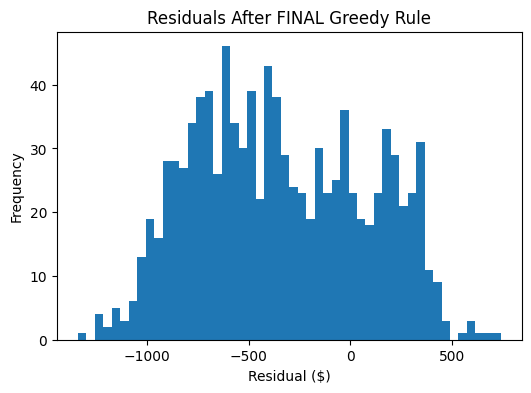

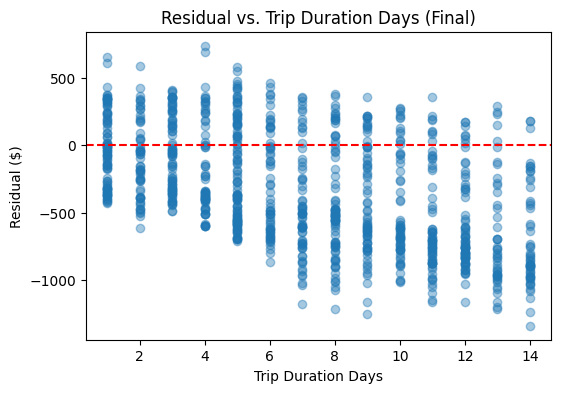

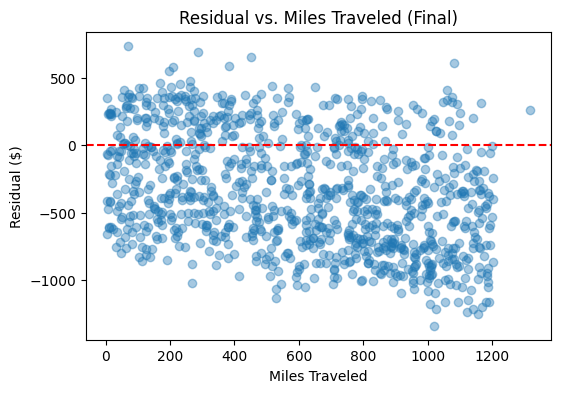

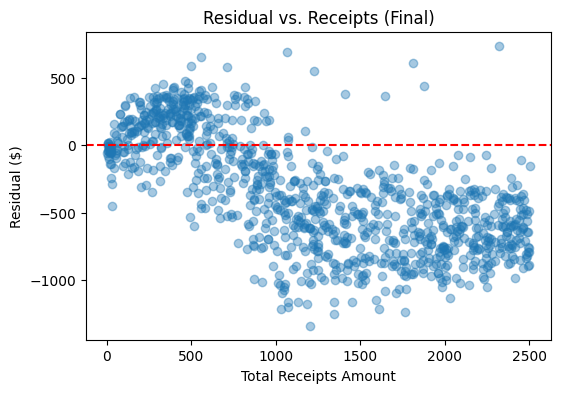

In [6]:
import matplotlib.pyplot as plt

# Histogram
plt.figure(figsize=(6, 4))
plt.hist(df['greedy_final_residual'], bins=50)
plt.title('Residuals After FINAL Greedy Rule')
plt.xlabel('Residual ($)')
plt.ylabel('Frequency')
plt.show()

# Residual vs. Trip Duration
plt.figure(figsize=(6, 4))
plt.scatter(df['trip_duration_days'], df['greedy_final_residual'], alpha=0.4)
plt.title('Residual vs. Trip Duration Days (Final)')
plt.xlabel('Trip Duration Days')
plt.ylabel('Residual ($)')
plt.axhline(0, color='red', linestyle='--')
plt.show()

# Residual vs. Miles
plt.figure(figsize=(6, 4))
plt.scatter(df['miles_traveled'], df['greedy_final_residual'], alpha=0.4)
plt.title('Residual vs. Miles Traveled (Final)')
plt.xlabel('Miles Traveled')
plt.ylabel('Residual ($)')
plt.axhline(0, color='red', linestyle='--')
plt.show()

# Residual vs. Receipts
plt.figure(figsize=(6, 4))
plt.scatter(df['total_receipts_amount'], df['greedy_final_residual'], alpha=0.4)
plt.title('Residual vs. Receipts (Final)')
plt.xlabel('Total Receipts Amount')
plt.ylabel('Residual ($)')
plt.axhline(0, color='red', linestyle='--')
plt.show()

In [7]:
df.sort_values('abs_greedy_final_residual', ascending=False).head(20).to_csv('outliers_after_greedy_final.csv', index=False)

In [11]:
df['abs_greedy_final_residual'] = df['greedy_final_residual'].abs()
print("\nTop 10 outliers after greedy rule 1:")
print(df.sort_values('abs_greedy_final_residual', ascending=False)[[
    'trip_duration_days','miles_traveled','total_receipts_amount','expected_output','greedy_predicted_v1','greedy_residual_v1'
]].head(10))


Top 10 outliers after greedy rule 1:


KeyError: "['greedy_predicted_v1', 'greedy_residual_v1'] not in index"